# Loader

**PYTHON 3.6**

Выкачивать через `Aspera` огромные архивы неудобно 

хотя может и существует норм способ, я пока не нашел( 

Попробуем написать кастомный загрузчик обращаясь напрямую через API просмотра файла.

Пример запроса:
    
```
https://pathology.cancerimagingarchive.net/pathdata/fcgi-bin/iipsrv.fcgi?DeepZoom=/data/cptac/images/9f905736-f662-41d6-b3ac-16758d_D1_D1.svs_files/15/31_61.jpg
```

In [1]:
import io
import shutil
import requests

import asyncio
import aiohttp
import time
from glob import glob

from matplotlib import pyplot as plt
import cv2 as cv
import numpy as np


from typing import Optional, Any, Dict, List, Tuple, Union
from tqdm import tqdm

from pathlib import Path
import pickle
import os

In [2]:
import tifffile

# try to obtain one tile

In [3]:
SAMPLE_URL_TILE = 'https://histologyslides.med.umich.edu/Images/Histology/Digestive%20System/'+\
                  'Intestines/176_HISTO_40X.zif?t1662319687811n577'

In [12]:
SAMPLE_URL_TILE = 'https://histologyslides.med.umich.edu/Images/Histology/Lymphatic%20System/'+\
                    '147B_HISTO_40X.zif?t1662322433821n202'


In [17]:
SAMPLE_URL_TILE = 'https://histologyslides.med.umich.edu/Images/Histology/Lymphatic%20System/'+\
                  '301_HISTO_40X.zif?t1662323235754n245'


In [19]:
SAMPLE_URL_TILE = 'https://histologyslides.med.umich.edu/Images/Histology/Male%20Reproductive%20System/'+\
                  '281_HISTO_40X.zif?t1662323985705n127'


In [38]:
SAMPLE_URL_TILE = 'https://histologyslides.med.umich.edu/Images/Histology/Respiratory%20System/' +\
                  '130-1_HISTO_40X.zif?t1662324222093n259'

In [4]:
SAMPLE_URL_TILE = 'https://histologyslides.med.umich.edu/Images/Histology/Digestive%20System/' +\
                  'Intestines/177_HISTO_40X.zif?t1662498301027n1355'

In [7]:
SAMPLE_URL_TILE = 'https://histologyslides.med.umich.edu/Images/Histology/Lymphatic%20System/' +\
                  '148_HISTO_20X.zif?t1662498826056n212'

In [11]:
SAMPLE_URL_TILE = 'https://histologyslides.med.umich.edu/Images/Histology/Respiratory%20System/' +\
                  '132_HISTO_40X.zif?t1662500489460n241'

In [15]:
SAMPLE_URL_TILE = 'https://histologyslides.med.umich.edu/Images/Histology/Respiratory%20System/' +\
                  '130-2_HISTO_40X.zif?t1662506713725n212'

In [16]:
response = requests.get(SAMPLE_URL_TILE, stream=True)
with open('lung_histologyslides_130-2_HISTO_40X.zif', 'wb') as out_file:
    shutil.copyfileobj(response.raw, out_file)
del response

In [40]:
img = tifffile.imread('./lung_histologyslides_130-1_HISTO_40X.zif')

In [41]:
img.shape

(74179, 117370, 3)

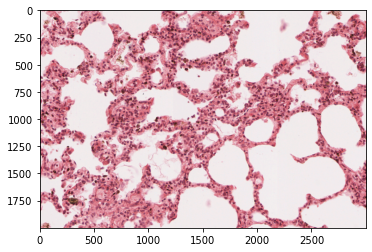

In [46]:
slc = img[45000:47000, 80000:83000]
plt.imshow(slc)
plt.show()

In [47]:
cv.imwrite('./lung_histologyslides_130-1_HISTO_40X_slc2.png', slc[:, :, ::-1])

True

In [4]:
SAMPLE_URL_NON_EXISTING_TILE = 'https://pathology.cancerimagingarchive.net/pathdata/' +\
    'fcgi-bin/iipsrv.fcgi?DeepZoom=/data/cptac/images/Oct2019/152789.svs_files/16/159_10700.jpg'

In [6]:
2+2

4

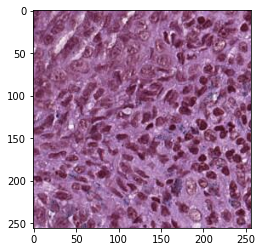

In [5]:
img = cv.imread('./test_img.zif')
plt.imshow(img)
plt.show()

In [6]:
response = requests.get(SAMPLE_URL_NON_EXISTING_TILE, stream=True)

In [7]:
response.status_code == 404

True

# loader

In [8]:
TILE_SIZE = 256

In [9]:
class CIATileLoader:
    def __init__(self):
        pass
    
    @staticmethod
    def make_url_by_params(pth: Optional[str], case: str, level: int, 
                            tile_x: int, tile_y: int) -> str:
        if pth is not None:
            url = 'https://pathology.cancerimagingarchive.net/pathdata/' +\
                f'fcgi-bin/iipsrv.fcgi?DeepZoom=/data/cptac/images/{pth}/{case}.svs_files/{level}/{tile_x}_{tile_y}.jpg'
        else:
            url = 'https://pathology.cancerimagingarchive.net/pathdata/' +\
                f'fcgi-bin/iipsrv.fcgi?DeepZoom=/data/cptac/images/{case}.svs_files/{level}/{tile_x}_{tile_y}.jpg'
        return url
    
    @staticmethod
    def parse_response(response_raw):
        image_stream = io.BytesIO()
        shutil.copyfileobj(response_raw, image_stream)
        image_stream.seek(0)
        file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
        img = cv.imdecode(file_bytes, cv.IMREAD_COLOR)
        return img
    
    @staticmethod
    def load_tile(url: str) -> Union[None, 'np.ndarray', str]:
        try:
            response = requests.get(url, stream=True)
            if response.status_code == 404:
                return '404'
        except requests.ConnectionError:
            return 'conn'
        
        img = CIATileLoader.parse_response(response.raw)

        return img
    
    def load_tile_by_params(self, pth: Optional[str], case: str, level: int, 
                            tile_x: int, tile_y: int) -> Union[None, 'np.ndarray', str]:
        url = self.make_url_by_params(pth, case, level, tile_x, tile_y)
#         print(url)
        return self.load_tile(url)
    


In [10]:
async def get_async_tile(url, session):
    try:
        async with session.get(url=url) as response:
            resp = await response.read()            
#             print("Successfully got url {} with resp of length {}.".format(url, len(resp)))
            nparr = np.frombuffer(resp, np.uint8)
            img_np = cv.imdecode(nparr, cv.IMREAD_COLOR)
            return img_np

    except Exception as e:
        print(e)
        return None


async def get_async_pack(urls):
    async with aiohttp.ClientSession() as session:
        ret = await asyncio.gather(*[get_async_tile(url, session) for url in urls])
#     print("  Finalized {} samples".format(len(ret)))
    return ret

In [11]:
# async def get_async_tile(url):
#     print('Starting {}'.format(url))
#     response = await aiohttp.ClientSession().get(url)
#     data = await response.text()
#     print('{}: {} bytes: {}'.format(url, len(data), data))
#     return data

In [12]:
# !pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

In [13]:
class CIATileLoaderAsync:
    def __init__(self):
        pass
    
    def load_tiles_by_params(self, pth: Optional[str], case: str, level: int, 
                            tiles_x_y: List[Tuple[int, int]]) -> Union[None, 'np.ndarray', str]:
        
        urls = [CIATileLoader.make_url_by_params(pth, case, level, tile_x_y[0], tile_x_y[1]) for tile_x_y in tiles_x_y]
        start = time.time()
        loop = asyncio.get_event_loop()
#         async with aiohttp.ClientSession() as session:
#             futures = [get_async_tile(url, session) for url in urls]
#             loop = asyncio.get_event_loop()
#             loop.run_until_complete(asyncio.wait(futures))
        ret = loop.run_until_complete(get_async_pack(urls))
#         ret = asyncio.run(get_async_pack(urls))
        end = time.time()

        print('Got {} samples in {:3.2} seconds'.format(len(ret), end - start))
        
        return ret

In [14]:
class CIAImgLoader:
    def __init__(self):
        self.tile_loader = CIATileLoader()
        self.async_loader = CIATileLoaderAsync()
        self.cache_x0 = []
        self.cache_y0 = []
    
    def determine_size(self, pth: Optional[str], case: str, level: int):
        # horizontal
        
        size_x = 0
        size_y = 0
        
        print('>> Determining Y size...')
        left = 0
        right = 4000
        while (right - left > 1):
            mid = (left + right) // 2
            result = self.tile_loader.load_tile_by_params(pth=pth, case=case, level=level, tile_x=0, tile_y=mid)
            if isinstance(result, np.ndarray):
                left = mid
            elif result == '404':
                right = mid
            else:
                raise ValueError("Idk what's wrong, maybe internet?")
        size_y = left
            
        print('>> Determining X size...')
        left = 0
        right = 150000  # not a mistake, it s because of div mod tile arithmetic
        while (right - left > 1):
            mid = (left + right) // 2
            result = self.tile_loader.load_tile_by_params(pth=pth, case=case, level=level, tile_x=mid, tile_y=0)
            if isinstance(result, np.ndarray):
                left = mid
            elif result == '404':
                right = mid
            else:
                raise ValueError("Idk what's wrong, maybe internet?")
        size_x = (left // (size_y + 1))
        
        print('>> Sample: detected tile size: [{}, {}]'.format(size_x, size_y))
        
        return size_x, size_y
    
    def load_entire_file(self, pth: Optional[str], case: str, level: int, output_path:str, batch_size=128):
        Path(output_path).mkdir(parents=True, exist_ok=True)
        
        shape = self.determine_size(pth, case, level)
        
        urls = []
        for x in range(shape[0]):
            for y in range(shape[1]):
                url = self.tile_loader.make_url_by_params(pth, case, level, x, y)
                urls.append((url, x, y))
                
        print('>> To download tiles : {}'.format(len(urls)))
        
        for index, step in enumerate(range(0, len(urls), batch_size)):
            dct = {}
            
            slc_urls = urls[step:step + batch_size]
            
            coords = list(zip(*list(zip(*slc_urls))[1:]))
            
            patches = self.async_loader.load_tiles_by_params(pth, case, level, coords)
            
            dct['patches'] = patches
            dct['urls'] = slc_urls
            dct['size'] = shape
        
            with open(os.path.join(output_path, '{:05d}.pkl'.format(index)), 'wb') as f:
                pickle.dump(dct, f)
                
            n = step + len(slc_urls)
            print('Completed {:05d}/{:05d} ({:3.1f} %)'.format(n, len(urls), n * 100.0 / len(urls)))

In [22]:
class CIABuildCanvas:
    def __init__(self):
        pass
    
    def merge_canvas(self, path_to_sample: str) -> np.ndarray:
        print('>> Merging canvas...')
        with open(os.path.join(path_to_sample, '00000.pkl'), 'rb') as f:
            data = pickle.load(f)
            
        W, H = data['size']
        W += 1
        H += 1
        
        canvas = np.zeros((H * TILE_SIZE, W * TILE_SIZE, 3), dtype=np.uint8)
        
        for fname in tqdm(sorted(glob(os.path.join(path_to_sample, '*.pkl')))):
            with open(fname, 'rb') as f:
                data = pickle.load(f)

            for i in range(len(data['patches'])):
                record = data['urls'][i]
                x = record[1] * TILE_SIZE
                y = record[2] * TILE_SIZE
                if data['patches'][i] is not None:
                    canvas[y:y+TILE_SIZE, x:x+TILE_SIZE] = data['patches'][i]
        
        output_fname = os.path.join(path_to_sample, 'sample.npy')
        np.save(output_fname, canvas)
        print('Output image saved to `{}`'.format(output_fname))
        return canvas
        
    def clean_pickles(self, path_to_sample: str):
        print('>> Cleaning pickles...')
        for fname in glob(os.path.join(path_to_sample, '*.pkl')):
            os.remove(fname)

In [23]:
cia_img_loader = CIAImgLoader()
cia_canvas = CIABuildCanvas()
ROOT_PATH = './../other_data/lung_CPTAC_LSCC/tissues/'

In [24]:
def load_img_from_ICA(pth, case, level, batch_size, sample_id, root_path):
    path_to_sample = os.path.join(root_path, sample_id)
    cia_img_loader.load_entire_file(pth=pth, case=case, 
                                    level=level, output_path=path_to_sample, batch_size=batch_size)
    cia_canvas.merge_canvas(path_to_sample)
    cia_canvas.clean_pickles(path_to_sample)

In [25]:
# load_img_from_ICA(
#     pth=None,
#     case='C3L-02646-24', 
#     level=17, 
#     batch_size=1024, 
#     sample_id='C3L-02646-24',
#     root_path=ROOT_PATH
# )

In [32]:
cases = """C3N-00221-24
C3N-00221-25
C3N-01017-23
C3N-02434-22
C3L-02646-24
C3L-04887-22
C3L-04379-21
C3L-02649-25
C3L-02649-21
C3L-04878-23
C3N-01018-24
C3L-04367-22
C3L-05395-21
C3L-05393-22
C3L-05020-25
C3L-05176-24
C3L-03965-23
C3L-03965-24
C3L-05145-25
C3L-05145-23
C3L-04856-21
C3L-04856-23
"""

cases = """
""".split()

#
# 
# C3L-05148-22""".split()


In [ ]:
https://pathology.cancerimagingarchive.net/pathdata/fcgi-bin/iipsrv.fcgi?DeepZoom=/data/cptac/images/Jan2020/150818.svs_files/13/14_1.jpg

In [47]:
load_img_from_ICA(
    pth='Jan2020',
    case='150818', 
    level=17, 
    batch_size=1024, 
    sample_id='C3L-05148-22',
    root_path=ROOT_PATH
)

>> Determining Y size...
>> Determining X size...
>> Sample: detected tile size: [334, 109]
>> To download tiles : 36406
Got 1024 samples in 4.6 seconds
Completed 01024/36406 (2.8 %)
Got 1024 samples in 2.8 seconds
Completed 02048/36406 (5.6 %)
Got 1024 samples in 2.3 seconds
Completed 03072/36406 (8.4 %)
Got 1024 samples in 2.1 seconds
Completed 04096/36406 (11.3 %)
Got 1024 samples in 2.2 seconds
Completed 05120/36406 (14.1 %)
Got 1024 samples in 2.2 seconds
Completed 06144/36406 (16.9 %)
Got 1024 samples in 2.1 seconds
Completed 07168/36406 (19.7 %)
Got 1024 samples in 2.1 seconds
Completed 08192/36406 (22.5 %)
Got 1024 samples in 2.2 seconds
Completed 09216/36406 (25.3 %)
Got 1024 samples in 2.4 seconds
Completed 10240/36406 (28.1 %)
Got 1024 samples in 7.4 seconds
Completed 11264/36406 (30.9 %)
Got 1024 samples in 2.8 seconds
Completed 12288/36406 (33.8 %)
Got 1024 samples in 3.0 seconds
Completed 13312/36406 (36.6 %)
Got 1024 samples in 3.0 seconds
Completed 14336/36406 (39.4 %)


100%|██████████| 36/36 [00:11<00:00,  3.23it/s]


Output image saved to `./../other_data/lung_CPTAC_LSCC/tissues/C3L-05148-22/sample.npy`
>> Cleaning pickles...


In [ ]:
for i, case in enumerate(cases):
    print('-'*80)
    print('[{:02d}/{:02d}] CASE:'.format(i + 1, len(cases)), case)
    print('-'*80)
    load_img_from_ICA(
        pth=None,
        case=case, 
        level=17, 
        batch_size=1024, 
        sample_id=case,
        root_path=ROOT_PATH
    )

# usage of particular classes

In [88]:
res = CIATileLoaderAsync().load_tiles_by_params(pth='Oct2019', case='152789', level=16,
                                       tiles_x_y=[(159, 107), (159, 108), (159, 109)] 
                                       )

Successfully got url https://pathology.cancerimagingarchive.net/pathdata/fcgi-bin/iipsrv.fcgi?DeepZoom=/data/cptac/images/Oct2019/152789.svs_files/16/159_108.jpg with resp of length 18671.
Successfully got url https://pathology.cancerimagingarchive.net/pathdata/fcgi-bin/iipsrv.fcgi?DeepZoom=/data/cptac/images/Oct2019/152789.svs_files/16/159_107.jpg with resp of length 19182.
Successfully got url https://pathology.cancerimagingarchive.net/pathdata/fcgi-bin/iipsrv.fcgi?DeepZoom=/data/cptac/images/Oct2019/152789.svs_files/16/159_109.jpg with resp of length 18635.
  Finalized 3 samples
Got 3 samples in 0.2689223289489746 seconds


In [170]:
CIAImgLoader().load_entire_file(pth='Oct2019', case='152789', level=16, output_path='./sample1', batch_size=1024)

>> Determining Y size...
>> Determining X size...
>> Sample: detected tile size: [210, 142]
>> To download tiles : 29820
  Finalized 1024 samples
Got 1024 samples in 2.7952158451080322 seconds
Completed 01024/29820 (3.4 %)
  Finalized 1024 samples
Got 1024 samples in 2.52471923828125 seconds
Completed 02048/29820 (6.9 %)
  Finalized 1024 samples
Got 1024 samples in 3.134425163269043 seconds
Completed 03072/29820 (10.3 %)
  Finalized 1024 samples
Got 1024 samples in 2.873457193374634 seconds
Completed 04096/29820 (13.7 %)
  Finalized 1024 samples
Got 1024 samples in 2.715330123901367 seconds
Completed 05120/29820 (17.2 %)
  Finalized 1024 samples
Got 1024 samples in 3.6976609230041504 seconds
Completed 06144/29820 (20.6 %)
  Finalized 1024 samples
Got 1024 samples in 2.9815549850463867 seconds
Completed 07168/29820 (24.0 %)
  Finalized 1024 samples
Got 1024 samples in 2.9774186611175537 seconds
Completed 08192/29820 (27.5 %)
  Finalized 1024 samples
Got 1024 samples in 3.07509183883667 